my_translator
=

<br><br>

# 목차
## 1. 목표 및 의의
## 2. 이론
## 3. 코드
## 4. 회고

<br>

# 1. 목표 및 의의
## 1) Transformer를 낱낱히 뜯어본다.
## 2) 스스로 사용할만한 번역기에 도전해본다...!!

<br>

# 2. 이론
## Transformer

<br>

# 3. 코드

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


In [2]:
!nvidia-smi

Sun Jan  9 22:15:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   48C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화


print(tf.__version__)

2.4.1


In [4]:
def positional_encoding(pos_len, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos_len)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:,0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:,1::2])
    return sinusoid_table
    

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scale_dot_product_attention(self, Q, K, V, mask=None):
        d_k = tf.cast(K.shape[-1], tf.float32)
        # scaled qk 구하기

        QK_T = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK_T / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, *xs): # num_heads는 self에 있으니까 받을 필요 없음
        # MultiHead에 넣을려고 분할
        # x: [ batch x length x embedding_dimension ]
        # return: [ batch x heads x length x embedding_dimension]
        split_xs = []
        for x in xs:
            a,b,c = x.shape

            split_x = tf.reshape(x,(a,b,self.num_heads,self.depth))
            split_x = tf.transpose(split_x, (0,2,1,3))            
            split_xs.append(split_x)
            
        return split_xs


    def combine_heads(self, x):
        # 분할 계산을 마치고, 임베딩을 다시 결합한다.
        # x: [ batch x heads x length x depth ]
        # return: [ batch x length x emb ]
        x = tf.transpose(x,(0,2,1,3))
        a,b,c,d = x.shape

        concat_x = tf.reshape(x, (a,b,c*d))

        return concat_x


    def call(self, Q, K, V, mask=None): #[batch x len x 512 ]
        # 1: Linear_in(Q,K,V) -> WQ, WK, WV
        wq = self.W_q(Q)
        wk = self.W_k(K)
        wv = self.W_v(V)

        # 2: split heads
        W_qkv_split = self.split_heads(wq,wk,wv)

        # 3: scaled dot product attention
        out, attention_weights = self.scale_dot_product_attention(*W_qkv_split, mask)

        # 4: Combine Heads(out) -> out
        out = self.combine_heads(out)

        # 5: Linear_out(out) -> out
        out = self.linear(out)

        return out, attention_weights



In [6]:
class Position_wise_FFN(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(Position_wise_FFN, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self,x):
        out = self.w_1(x)
        out = self.w_2(out)
        return out


In [7]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = Position_wise_FFN(d_model,d_ff)

        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        # Multi-Head Attention
        residual = x

        out = self.norm1(x)
        out, enc_attn = self.enc_self_attn(out,out,out, mask)
        out = self.dropout(out)

        out += residual

        # position wise FFN
        residual2 = out
        out = self.norm2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual2

        return out, enc_attn



In [8]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dff, dropout):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
        self.dec_attn = MultiHeadAttention(d_model, n_heads)

        self.ffn = Position_wise_FFN(d_model,dff)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, x,y, causality_mask, padding_mask):
        residual = x
        out = self.norm1(x)
        out, dec_attn = self.dec_self_attn(out,out,out, padding_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm2(out)
        out, dec_enc_attn = self.dec_attn(out,y,y, causality_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn



In [9]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 dff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model,n_heads,dff,dropout) for _ in range(n_layers)]

    def call(self, x, mask):
        out = x

        enc_attns = []

        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns
        

In [10]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, dff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model,n_heads, dff, dropout) for i in range(n_layers)]

    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        
        dec_attns = []
        dec_enc_attns = []

        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out,enc_out, causality_mask, padding_mask)
            
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns
        

In [11]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers,d_model,
                 n_heads,dff,src_vocab_size,
                 tgt_vocab_size, pos_len,
                 dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_embedding = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_embedding = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.positional = positional_encoding(pos_len,d_model)

        self.encoder = Encoder(n_layers, d_model, n_heads, dff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, dff, dropout)
        
        self.out_linear = tf.keras.layers.Dense(tgt_vocab_size)
        self.dropout = dropout

        self.shared = shared

        if shared: self.out_linear.set_weights(tf.transpose(self.dec_embedding.weights))

    
    def embedding(self, emb, x):
        # share?
        seq_len = x.shape[1]
        out = emb(x)
        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.positional[np.newaxis, ...][:, :seq_len, :]

        return out

    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # 1 embedding
        enc = self.embedding(self.enc_embedding, enc_in)
        dec = self.embedding(self.dec_embedding, dec_in)

        # 2 encoder, decoder
        enc_out, enc_attns = self.encoder(enc, enc_mask)

        dec_out, dec_attns, dec_enc_attns = self.decoder(dec, enc_out, causality_mask, dec_mask)

        logits = self.out_linear(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns



In [12]:

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask


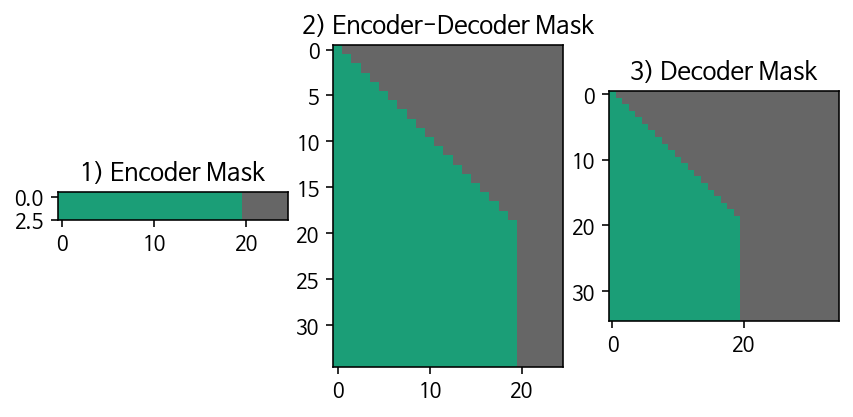

In [13]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [14]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)



In [15]:
now_path = "aiffel/Data/kor_en/"
path_to_enfile = "data/kor_en/korean-english-park.train.en"
path_to_kofile = "data/kor_en/korean-english-park.train.ko"
kor_path = now_path + path_to_enfile
eng_path = now_path + path_to_kofile

In [16]:

# 데이터 정제
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.readlines()
    with open(eng_path, "r") as f: eng = f.readlines()
    assert len(kor) == len(eng)
    print(len(kor))
    
    dataset = set()
    for i,j in zip(kor, eng):
        i = preprocess_sentence(i)
        j = preprocess_sentence(j)
        dataset.add((i,j))
    print(len(dataset))
    cleaned_corpus = list(dataset)
    return cleaned_corpus

In [17]:
import re
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'([?!,."])', r' \1 ',sentence)
    sentence = re.sub(r'[^A-zㄱ-ㅎㅏ-ㅣ가-힣0-9?!,."]', ' ', sentence)
    sentence = re.sub(r'[" "]+', ' ',sentence)
    sentence = sentence.strip()
    return sentence

cleaned_corpus = clean_corpus(kor_path, eng_path)


94123
78931


In [18]:
import sentencepiece as spm
import os

def generate_tokenizer(corpus,
                       vocab_size,
                       lang="ko",
                       pad_id=0,
                       bos_id=1,
                       eos_id=2,
                       unk_id=3):
    path = 'aiffel/Data/Model/transformer/'
    temp_file = f'{path}corpus_{lang}.temp'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix={path}spm_{lang} --vocab_size={vocab_size} --model_type=bpe'
    )
    
    s = spm.SentencePieceProcessor()
    s.Load(f'{path}spm_{lang}.model')
    print(f"{lang}-dict_num: {20000}")

    return s

In [19]:
eng, kor = zip(*cleaned_corpus)
print(kor[0])
ko = generate_tokenizer(kor,20000)
en = generate_tokenizer(eng,20000, lang="en")

모함마드미안 숨로 총리 대리인은 성명에서 이 같은 비겁한 행위를 저지른 자는 어떤 종교나 인간윤리를 믿는 신도가 아니다 라고 밝혔다 .
ko-dict_num: 20000
en-dict_num: 20000


In [20]:
def tokenize(corpus, tensorlen,voca_size):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=voca_size,filters='',)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=tensorlen)

    return tensor, tokenizer

In [21]:

path = 'aiffel/Data/Model/transformer/'
temp_file = f'{path}corpus_ko.temp'
ko_seq = []
with open(temp_file,'r') as f:
    for i in f.readlines():
        ko_seq.append(ko.SampleEncodeAsPieces(i,1, 0.0))
ko_tensor, ko_tokenizer = tokenize(ko_seq,50,20000)
print(ko_seq[0])
en_seq = []
temp_file = f'{path}corpus_en.temp'
with open(temp_file,'r') as f:
    for i in f.readlines():
        en_seq.append(en.SampleEncodeAsPieces(i,1, 0.0))
en_tensor, en_tokenizer = tokenize(en_seq,50,20000)
print(en_seq[0])

['▁모', '함', '마드', '미', '안', '▁숨', '로', '▁총리', '▁대리', '인은', '▁성명에서', '▁이', '▁같은', '▁비', '겁', '한', '▁행위를', '▁저지른', '▁자는', '▁어떤', '▁종교', '나', '▁인간', '윤', '리를', '▁믿는', '▁신', '도가', '▁아니다', '▁라고', '▁밝혔다', '▁.']
['▁caretaker', '▁prime', '▁minister', '▁mohammad', 'm', 'ian', '▁so', 'om', 'ro', '▁said', '▁in', '▁a', '▁statement', '▁that', '▁those', '▁who', '▁committed', '▁this', '▁cowardly', '▁act', '▁were', '▁neither', '▁belie', 'ver', '▁of', '▁any', '▁religion', '▁nor', '▁of', '▁any', '▁human', '▁ethics', '▁.']


In [22]:
print(f"ko dict voca: {len(ko_tokenizer.index_word)}")
print(f"en dict voca: {len(en_tokenizer.index_word)}")


ko dict voca: 20288
en dict voca: 19066


In [23]:
print(len(ko_seq), len(en_seq))
print(ko_seq[1], en_seq[1])

78931 78931
['▁윤', '광', '웅', '▁국방부', '▁장관', '▁,', '▁한국', '군이', '▁1', '월', '▁이라크', '▁총선', '▁동안', '▁감시', '단', '으로', '▁참여할', '▁가능성', '▁배제', '▁2005', '▁.', '▁08'] ['▁defense', '▁minister', '▁yoon', '▁ruled', '▁out', '▁a', '▁possibility', '▁that', '▁south', '▁korean', '▁troops', '▁would', '▁be', '▁engaged', '▁in', '▁combat', '▁or', '▁public', '▁security', '▁missions', '▁during', '▁a', '▁crucial', '▁iraqi', '▁national', '▁election', '▁in', '▁jan', '▁.']


In [24]:
en_tensor.shape

(78931, 50)

## 이렇게 케라스 토크나이저를 쓸 수도 있지만, 한번 sentencepiece를 조금 더 사용해보겠습니다.

In [25]:
def senten_tokenize(kor,eng, ko_model,en_model, max_len):
    kos = []
    ens = []
    for i,j in zip(kor,eng):
        i = preprocess_sentence(i)
        j = preprocess_sentence(j)
        ko = ko_model.EncodeAsIds(i)
        en = en_model.EncodeAsIds(j)
        if len(ko)>48 or len(en)>48: continue
        kos.append(ko)
        ens.append(en)
    ko_tensor = tf.keras.preprocessing.sequence.pad_sequences(kos, padding='post',maxlen=max_len)
    en_tensor = tf.keras.preprocessing.sequence.pad_sequences(ens, padding='post',maxlen=max_len)

    return ko_tensor, en_tensor

## 학습을 해도해도 결과가 안나와서 보니, 여기 전처리를 잘못했더라구요.
## 모델도 중요하지만, 누가 대신해주는 거 없으니, 정신 똑바로 차려야하겠습니다!

### decoder쪽 토그나이저는 set_encode_extra_options("bos:eos")을 해주어 시작, 끝 토큰을 추가할 수 있습니다.
### 

In [26]:
en.set_encode_extra_options("bos:eos")
ko_tensor,en_tensor = senten_tokenize(kor,eng, ko,en, 50)

In [27]:
from sklearn.model_selection import train_test_split

BUFFER_SIZE = 128
BATCH_SIZE = 128

enc_train, enc_val, dec_train, dec_val = \
train_test_split(ko_tensor, en_tensor, test_size=0.2) # 하... 여기 영어랑 한국어 순서 바뀌어 있었다..





dataset = tf.data.Dataset.from_tensor_slices((enc_train,dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))

dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((128, 50), (128, 50)), types: (tf.int32, tf.int32)>


<BatchDataset shapes: ((128, 50), (128, 50)), types: (tf.int32, tf.int32)>

In [28]:
train = dataset.__iter__()


In [29]:
a = next(train)[0]
print(a)

tf.Tensor(
[[11902  1388 17938 ...     0     0     0]
 [ 3884   146 18805 ...     0     0     0]
 [   27 18834 18857 ...     0     0     0]
 ...
 [   89   290 18918 ...     0     0     0]
 [ 3972 18806  5789 ...     0     0     0]
 [   89   132 18960 ...     0     0     0]], shape=(128, 50), dtype=int32)


In [30]:
transformer = Transformer(4,512,4,2048,20289,20001,50,shared=False)

# 와... 위대하다.
### 여기서 오류가 얼마나 떴는지 모르겠다.
### super은 init이라는 메소드가 없다는 부분부터, pos가 정의되지 않았다는 내용 등등. 설계를 똑바로 하니, 틀린부분이 어디인지 알아서 찾아준다는 점이 아주 뿌듯하다.

In [31]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [32]:
# ex = '''오바마는 대통령이다.
# 시민들은 도시 속에 산다.
# 커피는 필요 없다.
# 일곱 명의 사망자가 발생했다.'''
# ex = ex.split('\n')
# corpus = []
# for i in ex:
#     corpus.append(ko.SampleEncodeAsPieces(i,1, 0.0))
# for i in corpus:
#     print(i)
# tensor = ko_tokenizer.texts_to_sequences(corpus)

# tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=50)
# print(tensor)


In [33]:

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

## 문장이 짧아서 오히려 잘 안될지도 모른다는 걱정이 들지만, 논리적이지 않은 걱정인 것 같습니다..ㅎㅎ

In [40]:
transformer = Transformer(6,512,4,2048,20001,20001,50,shared=False)


In [41]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time


BUFFER_SIZE = 128
BATCH_SIZE = 128

enc_train, enc_val, dec_train, dec_val = \
train_test_split(ko_tensor, en_tensor, test_size=0.2)





dataset = tf.data.Dataset.from_tensor_slices((enc_train,dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))

dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset



@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns




@tf.function()
def eval_step(src,tgt, model):
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src,tgt)

    predictions, enc_attns, dec_attns, dec_enc_attns = model(src,tgt,enc_mask, dec_enc_mask, dec_mask)
    val_loss = loss_function(gold, predictions[:, :-1])
    
    
    return val_loss, enc_attns, dec_attns, dec_enc_attns



<BatchDataset shapes: ((128, 50), (128, 50)), types: (tf.int32, tf.int32)>


In [42]:

EPOCHS = 15



for epoch in range(EPOCHS):
    total_loss = 0
    val_loss = 0
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))[:-2]
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    train = dataset.__iter__()
    val = val_dataset.__iter__()

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(*next(train),
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))


    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))[:-2]
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            eval_step(*next(val),
                       transformer)
        
        val_loss += batch_loss
        
        t.set_description_str('Val_Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Val_loss %.4f' % (val_loss.numpy() / (batch + 1)))

    for ex in examples:
        translate(ex, transformer, ko, en)
    time.sleep(2)




Val_Epoch  1: 100%|██████████| 113/113 [01:03<00:00,  1.79it/s, Val_loss 6.5562]


Input: 오바마는 대통령이다.
Predicted translation: the the the the the , the , the , the .
Input: 시민들은 도시 속에 산다.
Predicted translation: the is the the the , the
Input: 커피는 필요 없다.
Predicted translation: the is the the the , the
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the the the the , the


Val_Epoch  2: 100%|██████████| 113/113 [01:00<00:00,  1.86it/s, Val_loss 6.0535]


Input: 오바마는 대통령이다.
Predicted translation: the the situation , the new new lot of the united states .
Input: 시민들은 도시 속에 산다.
Predicted translation: the new korean korean of the country .
Input: 커피는 필요 없다.
Predicted translation: the dow is not the new new lot of the new new new country .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the new korean korean of the country .


Val_Epoch  3: 100%|██████████| 113/113 [01:00<00:00,  1.87it/s, Val_loss 5.7525]


Input: 오바마는 대통령이다.
Predicted translation: obama , the nomination .
Input: 시민들은 도시 속에 산다.
Predicted translation: the man was a second .
Input: 커피는 필요 없다.
Predicted translation: i re a kind of the same .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the suicide wounded wounded at the wounded .


Val_Epoch  4: 100%|██████████| 113/113 [01:00<00:00,  1.86it/s, Val_loss 5.5600]


Input: 오바마는 대통령이다.
Predicted translation: i is a lot of the democratic democratic democratic democratic party .
Input: 시민들은 도시 속에 산다.
Predicted translation: the man is a good .
Input: 커피는 필요 없다.
Predicted translation: i can do going to be .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two people were injured .


Val_Epoch  5: 100%|██████████| 113/113 [01:00<00:00,  1.86it/s, Val_loss 5.4770]


Input: 오바마는 대통령이다.
Predicted translation: obama , obama cnn  ⁇ 
Input: 시민들은 도시 속에 산다.
Predicted translation: the truth is not be .
Input: 커피는 필요 없다.
Predicted translation: it is a lot of the situation .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the wounded was killed .


Val_Epoch  6: 100%|██████████| 113/113 [01:00<00:00,  1.87it/s, Val_loss 5.3235]


Input: 오바마는 대통령이다.
Predicted translation: president george obama , obama , and president bush .
Input: 시민들은 도시 속에 산다.
Predicted translation: the cause of the planet .
Input: 커피는 필요 없다.
Predicted translation: i can be safe .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two people were killed .


Val_Epoch  7: 100%|██████████| 113/113 [01:00<00:00,  1.86it/s, Val_loss 5.2956]


Input: 오바마는 대통령이다.
Predicted translation: obama president george obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the indian panda is now .
Input: 커피는 필요 없다.
Predicted translation: i can t be able to be a very dangerous .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eight people were killed .


Val_Epoch  8: 100%|██████████| 113/113 [01:00<00:00,  1.88it/s, Val_loss 5.2840]


Input: 오바마는 대통령이다.
Predicted translation: obama is a president  ⁇ 
Input: 시민들은 도시 속에 산다.
Predicted translation: the poison rooted is rooted .
Input: 커피는 필요 없다.
Predicted translation: if you can be rid of course .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eight people were wounded .


Val_Epoch  9: 100%|██████████| 113/113 [01:00<00:00,  1.86it/s, Val_loss 5.2648]


Input: 오바마는 대통령이다.
Predicted translation: president obama is president bush .
Input: 시민들은 도시 속에 산다.
Predicted translation: the elephants are in the midst of the city of the city of hindu city .
Input: 커피는 필요 없다.
Predicted translation: if you can you you you you you you you you .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eight people were killed .


Val_Epoch 10: 100%|██████████| 113/113 [01:00<00:00,  1.87it/s, Val_loss 5.3066]


Input: 오바마는 대통령이다.
Predicted translation: the president is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the indian is rooted .
Input: 커피는 필요 없다.
Predicted translation: if you can .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least seven people were killed .


Val_Epoch 11: 100%|██████████| 113/113 [01:00<00:00,  1.87it/s, Val_loss 5.3883]


Input: 오바마는 대통령이다.
Predicted translation: obama , who is president bush , president , obama , president , obama , is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the threatens rooted in the middle of the middle .
Input: 커피는 필요 없다.
Predicted translation: if you can store
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eight people were killed .


Val_Epoch 12: 100%|██████████| 113/113 [01:00<00:00,  1.87it/s, Val_loss 5.5044]


Input: 오바마는 대통령이다.
Predicted translation: obama is one of obama s inauguration .
Input: 시민들은 도시 속에 산다.
Predicted translation: hundreds of people are in the park .
Input: 커피는 필요 없다.
Predicted translation: if you can be able to ban .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


Val_Epoch 13: 100%|██████████| 113/113 [01:00<00:00,  1.87it/s, Val_loss 5.6656]


Input: 오바마는 대통령이다.
Predicted translation: he s a dream of care , he told illinois , february care in indiana care .
Input: 시민들은 도시 속에 산다.
Predicted translation: 82 year old kerts .
Input: 커피는 필요 없다.
Predicted translation: improve , ban is more more .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


Val_Epoch 14: 100%|██████████| 113/113 [01:00<00:00,  1.86it/s, Val_loss 5.7954]


Input: 오바마는 대통령이다.
Predicted translation: he is welcoming obama s lead in february .
Input: 시민들은 도시 속에 산다.
Predicted translation: some of the fires are collapsed .
Input: 커피는 필요 없다.
Predicted translation: improve coffee is not matched .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


Val_Epoch 15: 100%|██████████| 113/113 [01:00<00:00,  1.88it/s, Val_loss 5.9435]


Input: 오바마는 대통령이다.
Predicted translation: obama s annual october 29th .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the past week .
Input: 커피는 필요 없다.
Predicted translation: improve your product is .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were injured .


In [43]:
checkpoint_dir = "/aiffel/Data/Model/transformer/weight"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(transformer=transformer)

checkpoint.save(file_prefix=checkpoint_prefix)


'/aiffel/Data/Model/transformer/weight/ckpt-1'

In [34]:
from tqdm import tqdm

class Transformer(tf.keras.Model):
    def __init__(self, n_layers,d_model,
                 n_heads,dff,src_vocab_size,
                 tgt_vocab_size, pos_len, loss_function,
                 dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_embedding = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_embedding = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.positional = positional_encoding(pos_len,d_model)

        self.encoder = Encoder(n_layers, d_model, n_heads, dff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, dff, dropout)
        
        self.out_linear = tf.keras.layers.Dense(tgt_vocab_size)
        self.dropout = tf.keras.layers.SpatialDropout1D(dropout/2)

        self.shared = shared
        self.history = {'loss':[],'val_loss':[], 'attention':[]}

        self.loss_function = loss_function

        if shared: self.out_linear.set_weights(tf.transpose(self.dec_embedding.weights)) # 이런 생각을 한다는 것이 매우 놀랍다.

    
    def embedding(self, emb, x):
        # share?
        seq_len = x.shape[1]
        out = emb(x)
        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.positional[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # 1 embedding
        enc = self.embedding(self.enc_embedding, enc_in)
        dec = self.embedding(self.dec_embedding, dec_in)

        # 2 encoder, decoder
        enc_out, enc_attns = self.encoder(enc, enc_mask)

        dec_out, dec_attns, dec_enc_attns = self.decoder(dec, enc_out, causality_mask, dec_mask)

        logits = self.out_linear(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns
    
    def generate_padding_mask(self, seq):
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return seq[:, tf.newaxis, tf.newaxis, :]

    def generate_causality_mask(self, src_len, tgt_len):
        mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
        return tf.cast(mask, tf.float32)

    def generate_masks(self, src, tgt):
        enc_mask = self.generate_padding_mask(src)
        dec_mask = self.generate_padding_mask(tgt)

        dec_enc_causality_mask = self.generate_causality_mask(tgt.shape[1], src.shape[1])
        dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

        dec_causality_mask = self.generate_causality_mask(tgt.shape[1], tgt.shape[1])
        dec_mask = tf.maximum(dec_mask, dec_causality_mask)

        return enc_mask, dec_enc_mask, dec_mask

    @tf.function()
    def train_step(self, src, tgt, optimizer):
        gold = tgt[:, 1:]
            
        enc_mask, dec_enc_mask, dec_mask = self.generate_masks(src, tgt)

        with tf.GradientTape() as tape:
            predictions, enc_attns, dec_attns, dec_enc_attns = self(src, tgt, enc_mask, dec_enc_mask, dec_mask)
            loss = self.loss_function(gold, predictions[:, :-1])

        gradients = tape.gradient(loss, self.trainable_variables)    
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        return loss, enc_attns, dec_attns, dec_enc_attns




    @tf.function()
    def eval_step(self, src,tgt):
        gold = tgt[:, 1:]

        enc_mask, dec_enc_mask, dec_mask = self.generate_masks(src,tgt)

        predictions, enc_attns, dec_attns, dec_enc_attns = self(src,tgt,enc_mask, dec_enc_mask, dec_mask)
        val_loss = self.loss_function(gold, predictions[:, :-1])
        
        
        return val_loss, enc_attns, dec_attns, dec_enc_attns


    def fit(self, epochs=20, x_train=None, y_train=None,
            x_val=None, y_val=None, BATCH_SIZE=128, 
            offset_epoch=0, translate=None, examples=None):
        EPOCHS = epochs

        for epoch in range(EPOCHS):
            total_loss = 0
            val_loss = 0
            idx_list = list(range(0, x_train.shape[0], BATCH_SIZE))
            random.shuffle(idx_list)
            t = tqdm(idx_list)

            for (batch, idx) in enumerate(t):
                batch_loss, enc_attns, dec_attns, dec_enc_attns = \
                self.train_step(x_train[idx:idx+BATCH_SIZE],
                                y_train[idx:idx+BATCH_SIZE],
                                optimizer)

                total_loss += batch_loss
                
                t.set_description_str('Epoch %2d' % (offset_epoch+epoch + 1))
                t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            self.history['loss'].append(total_loss.numpy() / (batch + 1))

            if x_val is not None:
                idx_list = list(range(0, x_val.shape[0], BATCH_SIZE))[:-2]
                random.shuffle(idx_list)
                t = tqdm(idx_list)

                for (batch, idx) in enumerate(t):
                    batch_loss, enc_attns, dec_attns, dec_enc_attns = \
                        self.eval_step(x_val[idx:idx+BATCH_SIZE],
                                    y_val[idx:idx+BATCH_SIZE])
                    
                    val_loss += batch_loss
                    
                    t.set_description_str('Val_epoch %2d' % (offset_epoch+epoch + 1))
                    t.set_postfix_str('Val_loss %.4f' % (val_loss.numpy() / (batch + 1)))
                self.history['val_loss'].append(val_loss.numpy() / (batch + 1))

            if examples and translate:
                for ex in examples:
                    translate(ex, transformer, ko, en)
                time.sleep(2)

        self.history['attention'].extend([enc_attns, dec_attns, dec_enc_attns])
        return self.history


class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [36]:
transformer = Transformer(n_layers=4, d_model=512, n_heads=4, dff=2048, 
                          src_vocab_size=20000, tgt_vocab_size=20000, 
                          pos_len=50, loss_function=loss_function, dropout=0.4, shared=True)

In [37]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time


BATCH_SIZE = 256

enc_train, enc_val, dec_train, dec_val = \
train_test_split(ko_tensor, en_tensor, test_size=0.2)


examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

transformer.fit(20, enc_train, dec_train, enc_val, dec_val, BATCH_SIZE, translate=translate, examples=examples)

Val_epoch  1: 100%|██████████| 56/56 [00:41<00:00,  1.34it/s, Val_loss 6.7238]


Input: 오바마는 대통령이다.
Predicted translation: the .
Input: 시민들은 도시 속에 산다.
Predicted translation: the .
Input: 커피는 필요 없다.
Predicted translation: the .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the .


Val_epoch  2: 100%|██████████| 56/56 [00:40<00:00,  1.39it/s, Val_loss 5.9667]


Input: 오바마는 대통령이다.
Predicted translation: obama s a day .
Input: 시민들은 도시 속에 산다.
Predicted translation: the new york is a year .
Input: 커피는 필요 없다.
Predicted translation: the last year , the first time , the first time .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the government has been a new york .


Val_epoch  3: 100%|██████████| 56/56 [00:40<00:00,  1.40it/s, Val_loss 5.4245]


Input: 오바마는 대통령이다.
Predicted translation: obama s presidential candidate , mccain said .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the scene .
Input: 커피는 필요 없다.
Predicted translation: the t be a lot of the same .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the operation were killed .


Val_epoch  4: 100%|██████████| 56/56 [00:40<00:00,  1.40it/s, Val_loss 5.0912]


Input: 오바마는 대통령이다.
Predicted translation: obama is the democratic presidential election .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the city of the city of the city .
Input: 커피는 필요 없다.
Predicted translation: the cause of the t be the t .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the blast killed in the town of the town of the town .


Val_epoch  5: 100%|██████████| 56/56 [00:40<00:00,  1.39it/s, Val_loss 4.9163]


Input: 오바마는 대통령이다.
Predicted translation: obama is a lot of obama s presidential election .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the city s city .
Input: 커피는 필요 없다.
Predicted translation: the t be the t .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the storm killed in the town .


Val_epoch  6: 100%|██████████| 56/56 [00:40<00:00,  1.39it/s, Val_loss 4.8904]


Input: 오바마는 대통령이다.
Predicted translation: obama s presidential nominee , obama said .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the city is in the city .
Input: 커피는 필요 없다.
Predicted translation: the t seem to be a t .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a total of magnitude .


Val_epoch  7: 100%|██████████| 56/56 [00:39<00:00,  1.40it/s, Val_loss 5.0005]


Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re in the city .
Input: 커피는 필요 없다.
Predicted translation: there is no need for a donor
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the violence hit one was killed .


Val_epoch  8: 100%|██████████| 56/56 [00:40<00:00,  1.40it/s, Val_loss 5.2662]


Input: 오바마는 대통령이다.
Predicted translation: obama s speech is an obama speech at obama s presidential election .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s drive out .
Input: 커피는 필요 없다.
Predicted translation: but you don t need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


Val_epoch  9: 100%|██████████| 56/56 [00:40<00:00,  1.40it/s, Val_loss 5.6122]


Input: 오바마는 대통령이다.
Predicted translation: obama is the obama supporter of obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re choosing the city of marlboros .
Input: 커피는 필요 없다.
Predicted translation: no concept
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


Val_epoch 10: 100%|██████████| 56/56 [00:40<00:00,  1.40it/s, Val_loss 5.9253]


Input: 오바마는 대통령이다.
Predicted translation: obama is the illinois democratic nominee in obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re decapyang post .
Input: 커피는 필요 없다.
Predicted translation: no trace is no .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


Val_epoch 11: 100%|██████████| 56/56 [00:40<00:00,  1.39it/s, Val_loss 6.1870]


Input: 오바마는 대통령이다.
Predicted translation: obama s speech is the bush administration .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re down the city s boom .
Input: 커피는 필요 없다.
Predicted translation: we need no need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


Val_epoch 12: 100%|██████████| 56/56 [00:40<00:00,  1.39it/s, Val_loss 6.5146]


Input: 오바마는 대통령이다.
Predicted translation: obama s speech on obama s ability to come on obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s population is set .
Input: 커피는 필요 없다.
Predicted translation: but it s not just for membership .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


Val_epoch 13: 100%|██████████| 56/56 [00:40<00:00,  1.39it/s, Val_loss 6.6015]


Input: 오바마는 대통령이다.
Predicted translation: obama s speech , an obama speech at obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: city xenians smoke city .
Input: 커피는 필요 없다.
Predicted translation: there isn t no need for each other .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


Val_epoch 14: 100%|██████████| 56/56 [00:40<00:00,  1.39it/s, Val_loss 6.7933]


Input: 오바마는 대통령이다.
Predicted translation: obama is one of obama s presidency as the illinois issue office in thailand , obama is 18 .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is designed to fire at the acid .
Input: 커피는 필요 없다.
Predicted translation: no reason
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the injured were killed .


Val_epoch 15: 100%|██████████| 56/56 [00:39<00:00,  1.40it/s, Val_loss 6.9203]


Input: 오바마는 대통령이다.
Predicted translation: obama s inauguration is the obama issue of president obama s inauguration in obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they pitched in the city .
Input: 커피는 필요 없다.
Predicted translation: there is no need for nothing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


Val_epoch 16: 100%|██████████| 56/56 [00:40<00:00,  1.39it/s, Val_loss 7.0096]


Input: 오바마는 대통령이다.
Predicted translation: obama s act is the right .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re election in the city .
Input: 커피는 필요 없다.
Predicted translation: but it may not be a shower .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other germans were killed .


Val_epoch 17: 100%|██████████| 56/56 [00:40<00:00,  1.39it/s, Val_loss 7.1330]


Input: 오바마는 대통령이다.
Predicted translation: obama s presidential nominee , he said .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s air is now nice city .
Input: 커피는 필요 없다.
Predicted translation: there is no building in urgent .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the region .


Val_epoch 18: 100%|██████████| 56/56 [00:40<00:00,  1.39it/s, Val_loss 7.2958]


Input: 오바마는 대통령이다.
Predicted translation: obama is among the voters in his party , obama
Input: 시민들은 도시 속에 산다.
Predicted translation: city police say the city s pick .
Input: 커피는 필요 없다.
Predicted translation: it is not so much that it is so much .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were killed were injured .


Val_epoch 19: 100%|██████████| 56/56 [00:40<00:00,  1.40it/s, Val_loss 7.5066]


Input: 오바마는 대통령이다.
Predicted translation: obama s speech is expected to secure his resignation .
Input: 시민들은 도시 속에 산다.
Predicted translation: some cities in the city s office .
Input: 커피는 필요 없다.
Predicted translation: there is no place for work .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the violence was killed .


Val_epoch 20: 100%|██████████| 56/56 [00:40<00:00,  1.39it/s, Val_loss 7.7646]


Input: 오바마는 대통령이다.
Predicted translation: obama is the idea of president elect barack obama in a speech to the oval office .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s house is designed to fire .
Input: 커피는 필요 없다.
Predicted translation: the only thing we take it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


{'loss': ListWrapper([7.64802829908288, 6.305007536514946, 5.558072032099185, 4.961816936990489, 4.433119268002717, 3.8906730320142664, 3.316940971042799, 2.7584408967391303, 2.269750180451766, 1.8885673191236414, 1.6249701458474863, 1.4444156812584918, 1.3193210767663044, 1.216448045813519, 1.146894239342731, 1.0881391442340353, 1.0333062213400135, 0.9757387244183084, 0.8257028994352921, 0.6796265311863111]),
 'val_loss': ListWrapper([6.723758697509766, 5.9666611807686945, 5.424454280308315, 5.091202872140067, 4.916258130754743, 4.89043208530971, 5.00054441179548, 5.266178676060268, 5.6122332981654575, 5.925332205636161, 6.187019348144531, 6.514635358537946, 6.601523808070591, 6.793271200997489, 6.920317513602121, 7.009555271693638, 7.132958003452846, 7.2958205086844305, 7.506617409842355, 7.764560699462891]),
 'attention': ListWrapper([ListWrapper([<tf.Tensor: shape=(256, 4, 50, 50), dtype=float32, numpy=
 array([[[[2.57834252e-02, 9.95203257e-02, 2.77112611e-02, ...,
           0.00

In [56]:
checkpoint_dir = "/aiffel/Data/Model/transformer/weight"

checkpoint_prefix = os.path.join(checkpoint_dir, "uplayer2")
checkpoint = tf.train.Checkpoint(transformer=transformer)

checkpoint.save(file_prefix=checkpoint_prefix)

'/aiffel/Data/Model/transformer/weight/uplayer2-1'

# 4. 회고
## 1) 이걸로 며칠을 보내버렸는지 모르겠다. 처음 학습을 돌리고, 왜 종료토큰을 학습하지 못하는지 의문이 들었는데, 종료토큰을 학습한 적이 없었기 때문이였다. 참.... 세상에 이유없는 일은 없는 것인지도 모른다는 생각이 들었다.
## 2) 내 아이가 언어를 익힌 것 같은 기쁨이 들었다.